# Eye fitting from Damian et al 2013.

From this paper: https://www.nature.com/articles/nature12153



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#imports
import os
from pathlib import Path
import pandas as pd
import flexiznam as flz
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt
import numpy as np
import cv2
from cottage_analysis.utilities.plot_utils import get_img_from_fig, write_fig_to_video
from cottage_analysis.eye_tracking import eye_model_fitting

# Get data

In [92]:
project = 'blota_onix_pilote'
mouse = "BRAC6692.4a"
session = "S20221216"
recording = "Arena_dark_floor"
camera = "eye_camera"
video_time = "2022-12-16T11_26_01"

raw = Path(flz.PARAMETERS['data_root']['raw'])
processed = Path(flz.PARAMETERS['data_root']['processed'])

data_folder = raw / project / mouse / session / recording / camera
raw_video_file = data_folder / f"{camera}_{video_time}.mp4"
video_timestamps = data_folder / f"{camera}_timestamps_{video_time}.csv"
video_metadata = data_folder / f"{camera}_metadata_{video_time}.yml"

assert all([f.exists() for f in (raw_video_file, video_timestamps, video_metadata)])

data_folder = processed / project / mouse / session / recording / camera
video_file = data_folder / f"{camera}_{video_time}_cropped.mp4"
assert video_file.exists()

# Removal of specular highlights

Make binary masks to remove reflection of IR light



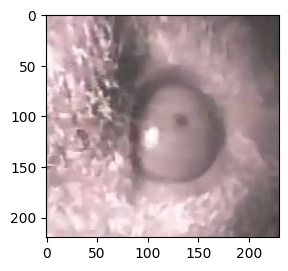

In [97]:
# example frame

frame_id = 24649

cam_data = cv2.VideoCapture(str(video_file))
cam_data.set(cv2.CAP_PROP_POS_FRAMES, frame_id-1)
ret, frame = cam_data.read()
cam_data.release()

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1, aspect='equal')
ax.imshow(frame)


## Filter for translation

A simpler filter to find eye translation. It is called $B_1$ in the paper and is simply a threshold:

$B_1 = I_{eye} \circ G > median(I_{eye}).\lambda _1$

Where $G$ is a gaussian filter (15x15 in their case) and $\lambda_1$ a user defined parameters (default to 2.5 in their case).

$B_2$ is $B_1$ with a morphological opening and closing and the final filter is:

$B_L = \neg (B_1 \land B_2)$

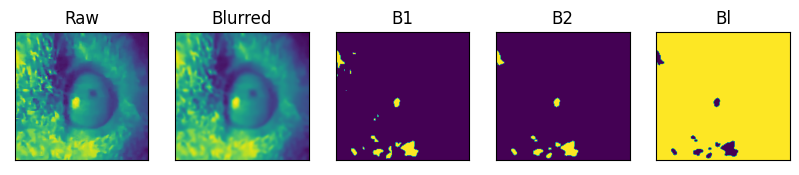

In [98]:
lambda1 = 1.5

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blurr = cv2.GaussianBlur(gray, (5,5), 5)
B1 = (blurr > np.nanmedian(gray) * lambda1).astype("uint8")

# Open and close once to remove speckles
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
B2 = cv2.morphologyEx(B1.astype('uint8'), cv2.MORPH_CLOSE, kernel)
B2 = cv2.morphologyEx(B2, cv2.MORPH_OPEN, kernel)

Bl = ~(B1&B2)

fig, axes = plt.subplots(1, 5)
fig.set_size_inches(10, 3)
axes[0].imshow(gray)
axes[1].imshow(blurr)
axes[2].imshow(B1)
axes[3].imshow(B2)
axes[4].imshow(Bl)

for i, t in enumerate(['Raw', 'Blurred', 'B1', 'B2', 'Bl']):
    axes.flatten()[i].set_title(t)
    axes.flatten()[i].set_xticks([])
    axes.flatten()[i].set_yticks([])

## Filter for pupil

It uses some ad-hoc filters, $F_x$ and $F_y$.

In [99]:
# Construct filters
H = np.ones([5, 5])
for corner in [(0,0), (0,-1), (-1, 0), (-1, -1)]:
    H[corner[0], corner[1]] = 0
print('H:')
print(H)

v = np.array([[-0.343, -0.171, 0, 0.171, 0.343]])
Fy = np.tile(v.T, 5) * H
print('Fy:')
print(Fy)
Fx = Fy.T

print('Fx:')
print(Fx)

H:
[[0. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0.]]
Fy:
[[-0.    -0.343 -0.343 -0.343 -0.   ]
 [-0.171 -0.171 -0.171 -0.171 -0.171]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.171  0.171  0.171  0.171  0.171]
 [ 0.     0.343  0.343  0.343  0.   ]]
Fx:
[[-0.    -0.171  0.     0.171  0.   ]
 [-0.343 -0.171  0.     0.171  0.343]
 [-0.343 -0.171  0.     0.171  0.343]
 [-0.343 -0.171  0.     0.171  0.343]
 [-0.    -0.171  0.     0.171  0.   ]]


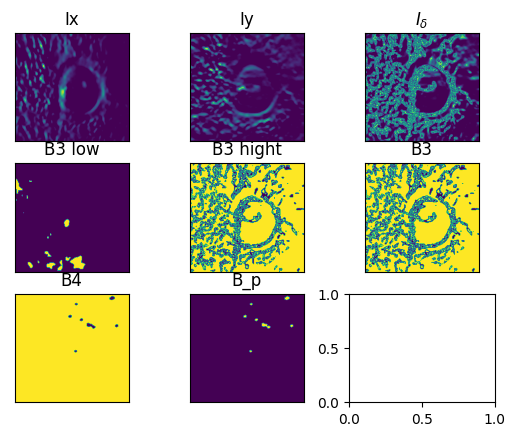

In [100]:
blurr_radius = 5
blurr = cv2.GaussianBlur(gray, (blurr_radius,blurr_radius), blurr_radius)
Ix =  cv2.filter2D(blurr, -1, Fx)
Iy =  cv2.filter2D(blurr, -1, Fy)
Idelta = Ix**2 + Iy**2

lambda2 = 1.5
lambda3 = 2.5
B3_low = (blurr > np.median(gray) * lambda2)
B3_high = (Idelta < np.median(Idelta) * lambda3**2)
B3 = B3_low | B3_high

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5, 5))
B4 = cv2.morphologyEx(B3.astype("uint8"), cv2.MORPH_CLOSE, kernel)
B4 = cv2.morphologyEx(B4.astype("uint8"), cv2.MORPH_OPEN, kernel)

Bp = ~(B3 | B4)

img_list = [Ix, Iy, Idelta, B3_low, B3_high, B3, B4, Bp]
titles = ["Ix", "Iy", r"$I_{\delta}$", "B3 low", "B3 hight", "B3", "B4", "B_p"]
fig, axes = plt.subplots(3, 3)
for i, (ax, img) in enumerate(zip(axes.flatten(), img_list)):
    ax.imshow(img_list[i].astype("uint8"))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])

In [101]:
blurr_radius = 7
blurr = cv2.GaussianBlur(gray, (blurr_radius,blurr_radius), blurr_radius)
Ix =  cv2.filter2D(blurr, -1, Fx)
Iy =  cv2.filter2D(blurr, -1, Fy)
Idelta = Ix**2 + Iy**2

lambda2 = 1.5
lambda3 = 3.5
B3_low = (blurr > np.median(gray) * lambda2)
B3_high = (Idelta < np.median(Idelta) * lambda3**2)
B3 = B3_low | B3_high

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
B4 = cv2.morphologyEx()
img_list = [Ix, Iy, Idelta, B3_low, B3_high, B3]
titles = ["Ix", "Iy", r"$I_{\delta}$", "B3 low", "B3 hight", "B3"]
fig, axes = plt.subplots(3, 3)
for i, (ax, img) in enumerate(zip(axes.flatten(), img_list)):
    ax.imshow(img_list[i].astype("uint8"))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'morphologyEx'
> Overload resolution failed:
>  - morphologyEx() missing required argument 'src' (pos 1)
>  - morphologyEx() missing required argument 'src' (pos 1)
